<center><b><font size=6>Unsupervised learning – clustering<b><center>

This notebook performs the following tasks for analyzing attack data.

0. **Install Dependencies**
1. **Determine the Number of Clusters**
2. **Tune Other Hyperparameters**
3. **Visualize the Clusters**
4. **Cluster Analysis**
5. **Assess Homogeneity and Intent Reflection**
6. **Associate Clusters with Specific Attack Categories**

<center><b><font size=5>Install Dependencies<b><center>

In [1]:
!python ../scripts/install_dependencies.py section3

Installing common packages: pandas, pyarrow
  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)
Installing Section 3 packages: numpy, matplotlib, seaborn, scikit-learn, wordcloud
  Using cached wordcloud-1.9.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (488 kB)


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from collections import Counter 
import itertools
import math

# utils
import sys
sys.path.append("../")
from scripts.data_storage_utils import save_plot

In [3]:
# Global variables
global_overwrite = True
plot_directory = "../results/figures/plots/section3"

<center><b><font size=5>Determine the Number of Clusters<b><center>

Identify the optimal number of clusters using evaluation methods like the Elbow Method or Silhouette Analysis.

**Steps:**

- Evaluate Data for Clustering
- Apply Clustering Evaluation Techniques
- Decide and Document

### Evaluate Data for Clustering

- Preprocess the text sessions (e.g., tokenize and vectorize using TF-IDF or word embeddings).
- Ensure data is normalized and ready for clustering.

In [4]:
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
SSH_Attacks

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,"[enable, system, shell, sh, cat, /proc/mounts,...",2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,"[cat, /proc/cpuinfo, grep, name, wc, -l, echo,...",2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,"[cat, /proc/cpuinfo, grep, name, wc, -l, echo,...",2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,"[cat, /proc/cpuinfo, grep, name, wc, -l, echo,...",2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,"[cat, /proc/cpuinfo, grep, name, wc, -l, echo,...",2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


In [6]:
df_features_tfidf_sampled = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf.parquet")


X = df_features_tfidf_sampled.drop(columns=["Set_Fingerprint"])
df_features_tfidf_sampled

,Set_Fingerprint,0kx34uax1rv,15s,172,192,20m,3s,75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw,8m,9p7vd0epz3tz,...,up,var,wc,wget,which,while,x13,x17,x19,xf
0,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
1,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
2,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
3,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
4,"[Defense Evasion, Discovery]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.154131,0.000000,0.156517,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067277,0.465673,0.133076,0.000000,0.066583,0.000000,0.0,0.0,0.0,0.0
233031,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067277,0.465673,0.133076,0.000000,0.066583,0.000000,0.0,0.0,0.0,0.0
233032,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067277,0.465673,0.133076,0.000000,0.066583,0.000000,0.0,0.0,0.0,0.0
233033,"[Discovery, Persistence]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.067277,0.465673,0.133076,0.000000,0.066583,0.000000,0.0,0.0,0.0,0.0


### Apply Clustering Evaluation Techniques

- Use the Elbow Method:
  - Calculate the sum of squared distances (inertia) for a range of cluster numbers.
  - Plot inertia vs. the number of clusters to identify the "elbow" point.
- Use Silhouette Analysis:
  - Compute the silhouette score for each potential cluster number.
  - Plot silhouette scores to find the number with the highest score.

### Decide and Document

- Select the optimal number of clusters based on the evaluation.
- Visualize and explain the reasoning with supporting metrics and charts.

In [7]:
# Step 1: Elbow Method
n_cluster_list=[]
inertia_list=[]
silhouette_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 17):
    kmeans_new = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cl_labels = kmeans_new.fit_predict(X)
        
    silhouette_value= silhouette_score(X, kmeans_new.labels_)
    silhouette_list.append(silhouette_value)

    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)

Overwriting file: '../results/figures/plots/section3/k-means_clustering_error.png'
Plot saved successfully at: '../results/figures/plots/section3/k-means_clustering_error.png'


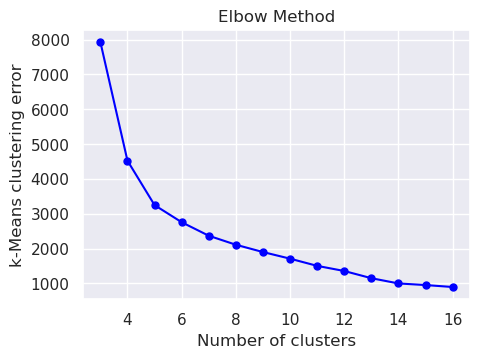

Overwriting file: '../results/figures/plots/section3/k-means_silohuette_score.png'
Plot saved successfully at: '../results/figures/plots/section3/k-means_silohuette_score.png'


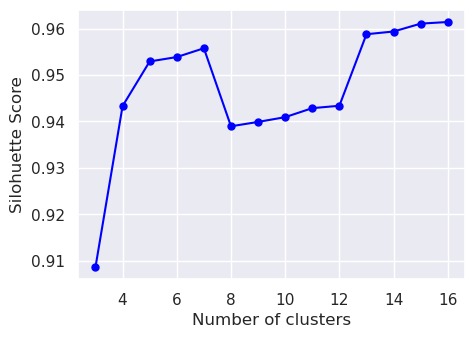

Size of each cluster:  [116175  83301  17628   5458    864    628    243    348   2328    201
   2977    753    211    441    138   1341]


In [8]:
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set_theme(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "k-means_clustering_error", "png", global_overwrite)

# Show the plot
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "k-means_silohuette_score", "png", global_overwrite)

# Show the plot
plt.show()

(unique, counts) = np.unique(kmeans_new.labels_, return_counts=True)
print("Size of each cluster: ", counts)

In [9]:
n_cluster_list=[]
silhouette_list_gmm= []
log_l_list=[]

for n_clusters in range(3, 17):
    gmm = GaussianMixture(n_components = n_clusters, random_state=42)
    gmm_label = gmm.fit_predict(X)
      
    silhouette_value = silhouette_score(X, gmm_label)
    silhouette_list_gmm.append(silhouette_value)
    
    log_l_list.append(gmm.score(X))
    n_cluster_list.append(n_clusters)

Overwriting file: '../results/figures/plots/section3/gmm_total_log-likelihood_score.png'
Plot saved successfully at: '../results/figures/plots/section3/gmm_total_log-likelihood_score.png'


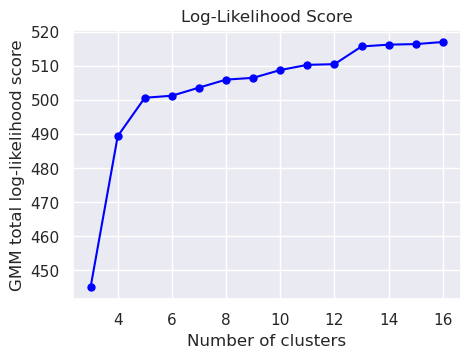

Overwriting file: '../results/figures/plots/section3/gmm_silohuette_score.png'
Plot saved successfully at: '../results/figures/plots/section3/gmm_silohuette_score.png'


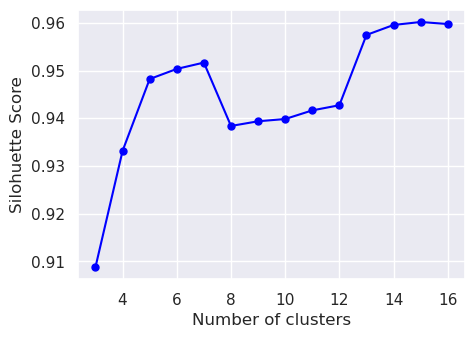

Effetive size of each cluster:  [0.49435063 0.35811788 0.07541786 0.02342137 0.00269487 0.00169073
 0.00368614 0.01277061 0.00272491 0.00086253 0.00106422 0.00090973
 0.01230716 0.00345442 0.00119725 0.00532967]


In [10]:
# Set up Seaborn style
sns.set_theme(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, log_l_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood Score')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "gmm_total_log-likelihood_score", "png", global_overwrite)

# Show the plot
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list_gmm, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')

# Save the plot
current_fig = plt.gcf()
save_plot(current_fig, plot_directory, "gmm_silohuette_score", "png", global_overwrite)

# Show the plot
plt.show()

# report effective size
print("Effetive size of each cluster: ", gmm.weights_)

<center><b><font size=5>Tune Other Hyperparameters<b><center>

## KMEANS

In [11]:
param_grid_kmeans = {
    'init': ['k-means++', 'random'],
    'n_init':  list(range(10, 21, 2)),
    'max_iter':  list(range(50, 200, 50)),
}

# Create KMeans object
kmeans = KMeans(n_clusters=10, random_state=42)

# Create RandomizedSearchCV object
grid_search_kmeans = GridSearchCV(kmeans, param_grid = param_grid_kmeans, cv=5)

# Fit the randomized search to your data
grid_search_kmeans.fit(X)  # X is your dataset

# Get the best parameters
best_params_kmenas = grid_search_kmeans.best_params_
print("Best parameters:", best_params_kmenas)

Best parameters: {'init': 'k-means++', 'max_iter': 50, 'n_init': 10}


In [12]:
kmeans_tuned = KMeans(n_clusters=10, init=best_params_kmenas['init'], n_init=best_params_kmenas['n_init'], max_iter=best_params_kmenas['max_iter'], random_state=42)
cl_labels_tuned = kmeans_tuned.fit_predict(X)
    
silhouette_value= silhouette_score(X, kmeans_tuned.labels_)

inertia = (kmeans_tuned.inertia_)
print("Silhouette: ", silhouette_value)
print("Inertia: ", inertia)

Silhouette:  0.9409264774019416
Inertia:  1708.9601949170567


## GMM

In [13]:
def silhouette_scorer(gmm, X):
    labels = gmm.fit_predict(X)
    return silhouette_score(X, labels)

param_grid_gmm = {
    'init_params': ['kmeans'], 
    'covariance_type': ['full', 'spherical'], # 'tied', 'diag' have been deleted because never selected
    'tol': [1e-3, 1e-4, 1e-5], 
    'max_iter': list(range(50, 300, 50)),
}

# Create GaussianMixture object
gmm = GaussianMixture(n_components=10,random_state=42)

# Create GridSearchCV object
grid_search_gmm = GridSearchCV(gmm, param_grid_gmm, cv=5, scoring = silhouette_scorer)

# Fit the grid search to your data
grid_search_gmm.fit(X)  # X is your dataset

# Get the best parameters
best_params_gmm = grid_search_gmm.best_params_
print("Best parameters:", best_params_gmm)

Best parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 50, 'tol': 0.001}


In [14]:
gmm_tuned = GaussianMixture(n_components = 10, random_state=42, init_params=best_params_gmm['init_params'], covariance_type=best_params_gmm['covariance_type'], max_iter=best_params_gmm['max_iter'], tol=best_params_gmm['tol'])
gmm_label_tuned = gmm_tuned.fit_predict(X)
    
silhouette_value = silhouette_score(X, gmm_label_tuned)

log_l_tuned = (gmm_tuned.score(X))

print("Silhouette: ", silhouette_value)
print("Log-l: ", log_l_tuned)

Silhouette:  0.9398368707211813
Log-l:  508.7118779885614


<center><b><font size=5>Visualize the Clusters: t-SNE<b><center>

Use t-SNE or UMAP to create clear visual representations of the clusters.

**Steps:**

- Reduce Dimensionality
- Create Visual Representations
- Analyze and Save

### Reduce Dimensionality

- Apply t-SNE or UMAP to reduce the data to two or three dimensions for visualization.
- Normalize or scale data if required by the algorithm.

In [15]:
# LET'S APPLY THE t-SNE TO THE DATASET, TO REDUCE THE NUMBER OF COMPONENTS

originalDF = pd.DataFrame(X)

tsne = TSNE(n_components=2, random_state=42).fit_transform(originalDF.values)

df_tsne = pd.DataFrame(tsne)
df_tsne

# NOW WE HAVE THE 2 COMPONENTS and WE CAN APPLY IT TO BOTH THE ALGORITHM

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,0,1
0,-1.703786,-12.167911
1,-1.703786,-12.167911
2,-1.703786,-12.167911
3,-1.703786,-12.167911
4,-1.703786,-12.167911
...,...,...
233030,1.439273,0.183800
233031,-0.046411,0.818869
233032,0.142102,-0.408442
233033,-1.064434,-3.327869


### Create Visual Representations

- Plot the data points with cluster assignments using a scatter plot:
  - Assign distinct colors to each cluster.
  - Add legends and labels for clarity.

## KMEANS

Overwriting file: '../results/figures/plots/section3/tsne_kmeans_clusters.png'
Plot saved successfully at: '../results/figures/plots/section3/tsne_kmeans_clusters.png'


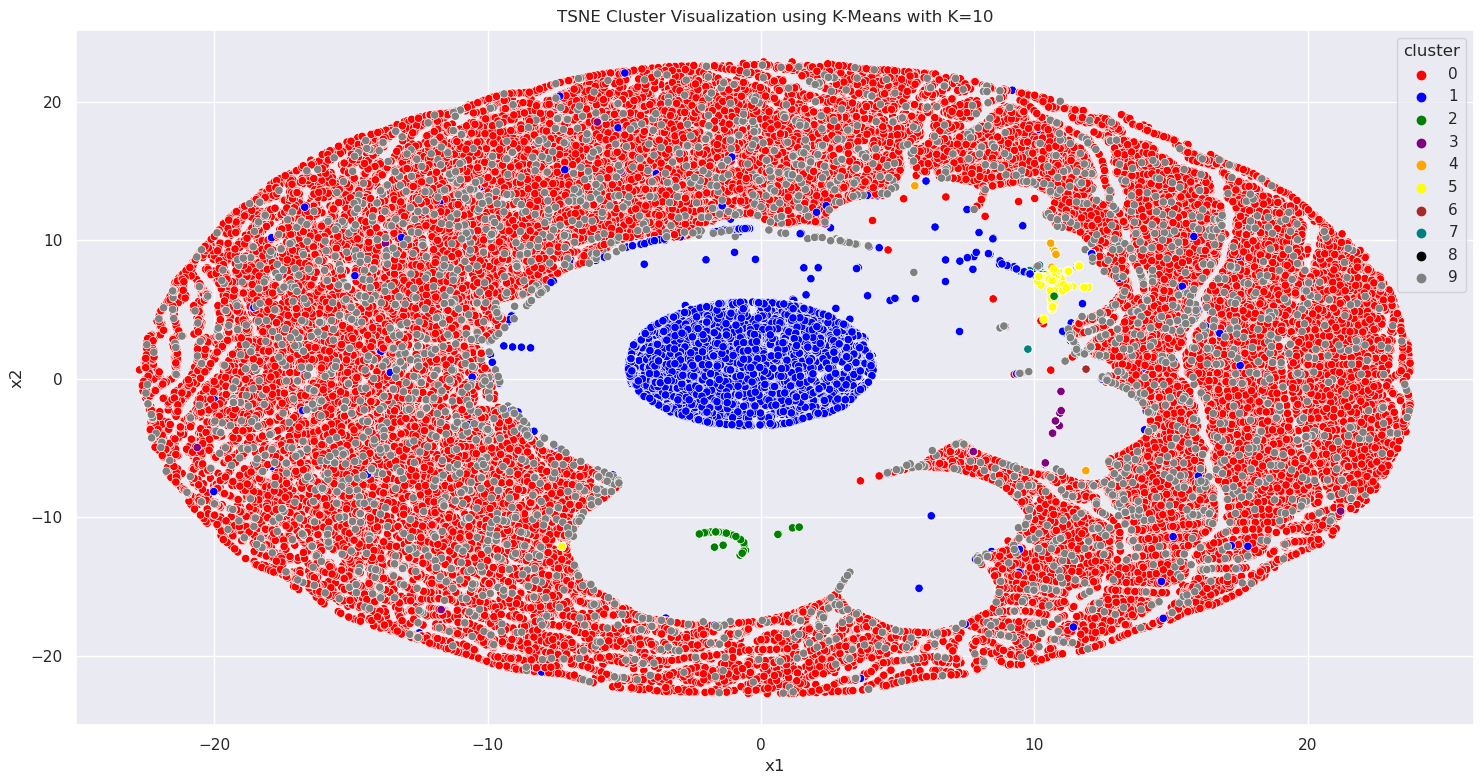

,x1,x2,cluster
0,-1.703786,-12.167911,2
1,-1.703786,-12.167911,2
2,-1.703786,-12.167911,2
3,-1.703786,-12.167911,2
4,-1.703786,-12.167911,2
...,...,...,...
233030,1.439273,0.183800,1
233031,-0.046411,0.818869,1
233032,0.142102,-0.408442,1
233033,-1.064434,-3.327869,1


In [16]:
labels_kmeans_tuned = kmeans_tuned.labels_

df_tsne_kmeans = pd.DataFrame(df_tsne)
df_tsne_kmeans["cluster"] = labels_kmeans_tuned
df_tsne_kmeans.columns = ["x1", "x2", "cluster"]

# Create the plot
fig, ax = plt.subplots(figsize=(15,8))

# Custom color palette to distinguish clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow", "brown", "teal", "black", "grey"]

sns.scatterplot(data=df_tsne_kmeans, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full")

ax.set_title('TSNE Cluster Visualization using K-Means with K=10')

# Save the plot
save_plot(fig, plot_directory, "tsne_kmeans_clusters", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

df_tsne_kmeans

## GMM

Overwriting file: '../results/figures/plots/section3/tsne_gmm_clusters.png'
Plot saved successfully at: '../results/figures/plots/section3/tsne_gmm_clusters.png'


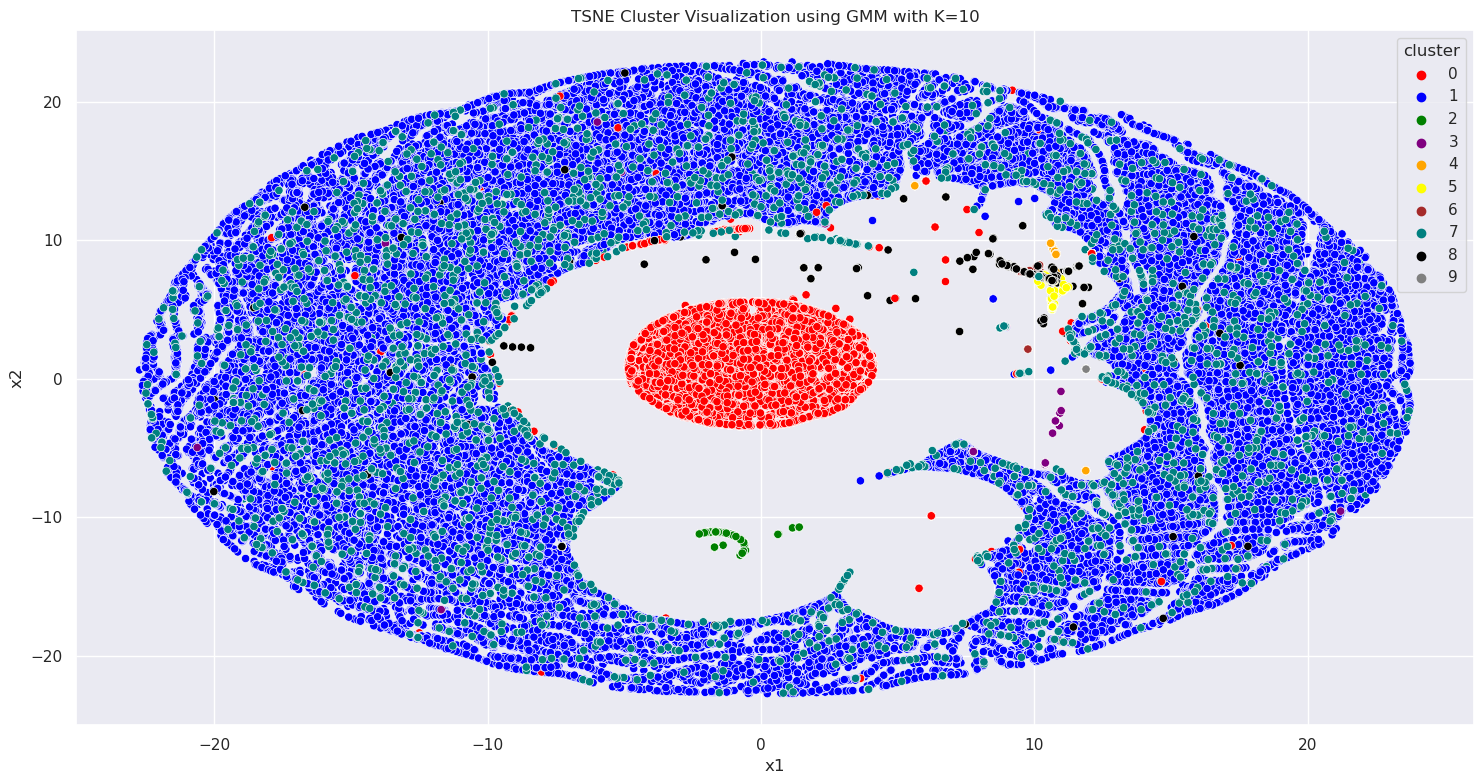

,x1,x2,cluster
0,-1.703786,-12.167911,2
1,-1.703786,-12.167911,2
2,-1.703786,-12.167911,2
3,-1.703786,-12.167911,2
4,-1.703786,-12.167911,2
...,...,...,...
233030,1.439273,0.183800,0
233031,-0.046411,0.818869,0
233032,0.142102,-0.408442,0
233033,-1.064434,-3.327869,0


In [17]:
labels_gmm_tuned = gmm_tuned.predict(X)

df_tsne_gmm = pd.DataFrame(df_tsne)
df_tsne_gmm["cluster"] = labels_gmm_tuned
df_tsne_gmm.columns = ["x1", "x2", "cluster"]

# Create the plot
fig, ax = plt.subplots(figsize=(15,8))

# Custom color palette to distinguish clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow", "brown", "teal", "black", "grey"]

sns.scatterplot(data=df_tsne_gmm, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full")

ax.set_title('TSNE Cluster Visualization using GMM with K=10')

# Save the plot
save_plot(fig, plot_directory, "tsne_gmm_clusters", "png", global_overwrite)

# Show the plot
plt.tight_layout()
plt.show()

df_tsne_gmm

### Analyze and Save

- Highlight overlaps or ambiguous clusters in the visualization.
- Save the plots and include them in your report for analysis.

,x1,x2,cluster
0,-1.703786,-12.167911,2
1,-1.703786,-12.167911,2
2,-1.703786,-12.167911,2
3,-1.703786,-12.167911,2
4,-1.703786,-12.167911,2
...,...,...,...
233030,1.439273,0.183800,0
233031,-0.046411,0.818869,0
233032,0.142102,-0.408442,0
233033,-1.064434,-3.327869,0


Overwriting file: '../results/figures/plots/section3/k-means_graph_visualization_of_cluster_0_with_communities.png'
Plot saved successfully at: '../results/figures/plots/section3/k-means_graph_visualization_of_cluster_0_with_communities.png'


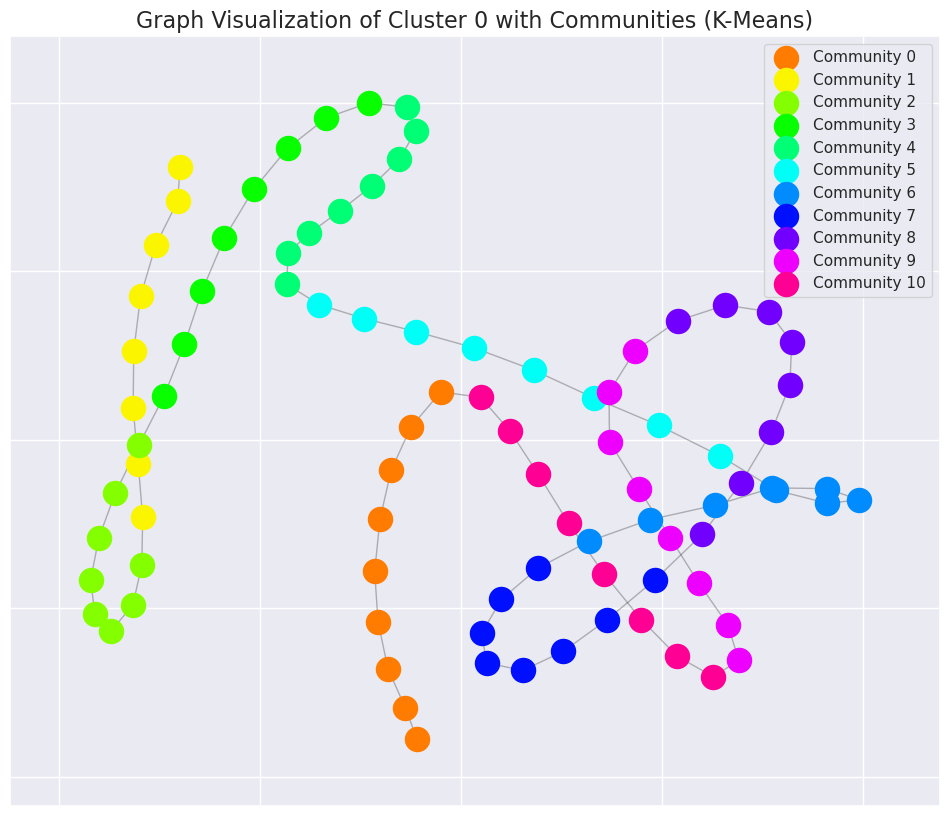

Cluster 0 - K-Means Community Analysis:
Community 0:
['var', 'wc', 'while', 'wget', 'x13', 'which', 'x17', 'x19', 'xf']


Community 1:
['8m', '20m', '15s', '0kx34uax1rv', '172', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '192', '3s']


Community 2:
['admin', 'bs', '9p7vd0epz3tz', 'bin', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'awk', 'authorizedkeys', 'bash']


Community 3:
['cpuinfo', 'chpasswd', 'chmod', 'cat', 'busybox', 'cd', 'count', 'cp']


Community 4:
['dota', 'done', 'do', 'dota3', 'dev', 'dd', 'echo', 'crontab']


Community 5:
['enable', 'go', 'free', 'exit', 'grep', 'gz', 'if', 'head']


Community 6:
['ls', 'initall', 'mdrfckr', 'lscpu', 'model', 'mkdir', 'lh', 'mem']


Community 7:
['mv', 'passwd', 'null', 'name', 'moun

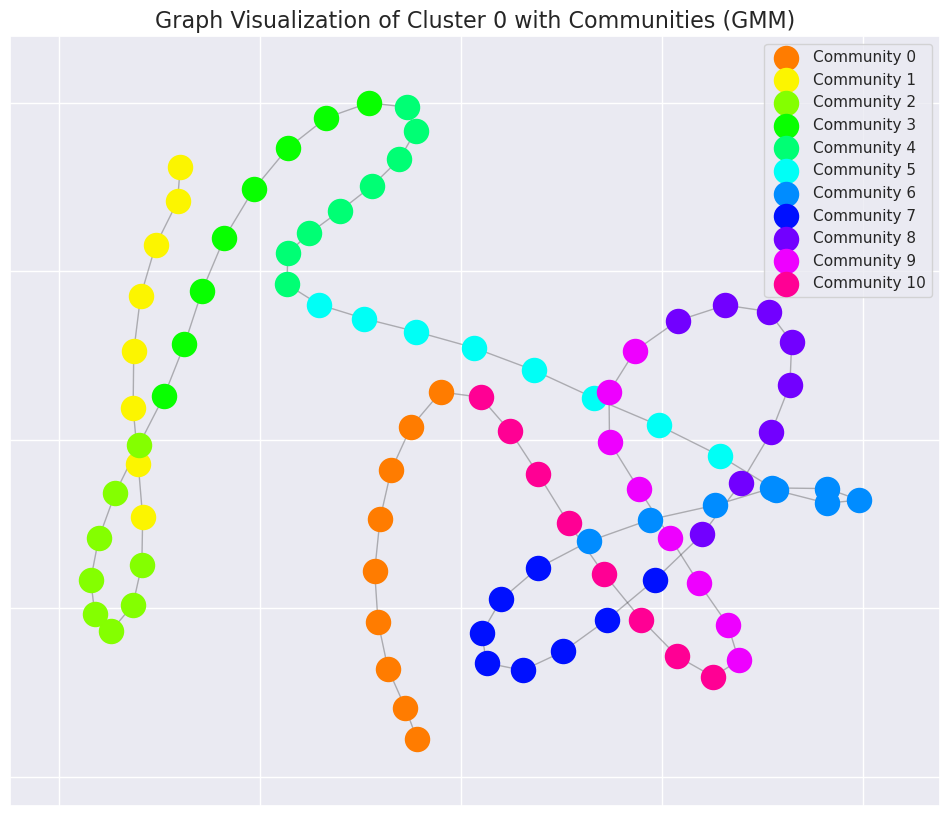

Cluster 0 - GMM Community Analysis:
Community 0:
['var', 'wc', 'while', 'wget', 'x13', 'which', 'x17', 'x19', 'xf']


Community 1:
['8m', '20m', '15s', '0kx34uax1rv', '172', '75gvomnx9euwonvnoaje0qxxziig9elbhpglmuakb5bgtfbrkjaw9u9fstdengvs8hx1knfs4mjux0hjok8rvcempecjdysymb66nylakgwcee6weqhmd1mupghwgq0hwcwsqk13ycgpk5w6hyp5zykfnvlc8hgmd4wwu97k6pftgtubjk14ujvcd9iukqttwyyjiiu5pmuux5bsz0r4wfwdie6i6rblaspkgaysvkprkorw', '192', '3s']


Community 2:
['admin', 'bs', '9p7vd0epz3tz', 'bin', 'aaaab3nzac1yc2eaaaabjqaaaqeardp4cun2lhr4kuhbge7vvacwdli2a8dbnrtorbmz15o73fcbox8nvbut0buanuv9tj2', 'awk', 'authorizedkeys', 'bash']


Community 3:
['cpuinfo', 'chpasswd', 'chmod', 'cat', 'busybox', 'cd', 'count', 'cp']


Community 4:
['dota', 'done', 'do', 'dota3', 'dev', 'dd', 'echo', 'crontab']


Community 5:
['enable', 'go', 'free', 'exit', 'grep', 'gz', 'if', 'head']


Community 6:
['ls', 'initall', 'mdrfckr', 'lscpu', 'model', 'mkdir', 'lh', 'mem']


Community 7:
['mv', 'passwd', 'null', 'name', 'mounts',

In [18]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_and_visualize_clusters(df_tsne, df_features_tfidf_sampled, method, plot_directory, global_overwrite):
    unique_clusters = df_tsne["cluster"].unique()
    
    for cluster in unique_clusters:
        print(f"Analyzing Cluster {cluster} - {method} Community Detection")
        
        cluster_indices = df_tsne[df_tsne["cluster"] == cluster].index
        cluster_sessions = df_features_tfidf_sampled.iloc[cluster_indices]
        
        # Create a graph for session relationships
        G = nx.Graph()
        for idx, row in cluster_sessions.iterrows():
            session_words = row.drop("Set_Fingerprint").index  # Example, replace with meaningful data
            for i in range(len(session_words) - 1):
                G.add_edge(session_words[i], session_words[i + 1])
        
        # Use a community detection algorithm
        communities = list(greedy_modularity_communities(G))
        
        # Visualize the graph with communities
        pos = nx.spring_layout(G, seed=42)
        plt.figure(figsize=(12, 10))
        colors = sns.color_palette('hsv', len(communities)).as_hex()
        
        for idx, community in enumerate(communities):
            nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=colors[idx], label=f'Community {idx}')
        nx.draw_networkx_edges(G, pos, alpha=0.3)
        
        plt.title(f'Graph Visualization of Cluster {cluster} with Communities ({method})', fontsize=16)
        plt.legend()
        
        # Save the plot
        current_fig = plt.gcf()
        save_plot(current_fig, plot_directory, f"{method.lower()}_graph_visualization_of_cluster_{cluster}_with_communities", "png", global_overwrite)
        
        # Show the plot
        plt.show()
        
        # Print community content
        print(f"Cluster {cluster} - {method} Community Analysis:")
        for idx, community in enumerate(communities):
            print(f"Community {idx}:")
            print(list(community)[:10])  # Show first 10 nodes as example
            print("\n")

# Run analysis for both K-Means and GMM
analyze_and_visualize_clusters(df_tsne_kmeans, df_features_tfidf_sampled, "K-Means", plot_directory, global_overwrite)
analyze_and_visualize_clusters(df_tsne_gmm, df_features_tfidf_sampled, "GMM", plot_directory, global_overwrite)

<center><b><font size=5>Cluster Analysis<b><center>

Examine and interpret each cluster’s defining characteristics using word clouds and frequent terms.

**Steps:**

- Identify Key Characteristics
- Describe Cluster Patterns
- Document Insights

### Identify Key Characteristics

- Extract the most frequent words or phrases in each cluster.
- Generate word clouds to visually represent the distinctive terms for each cluster.

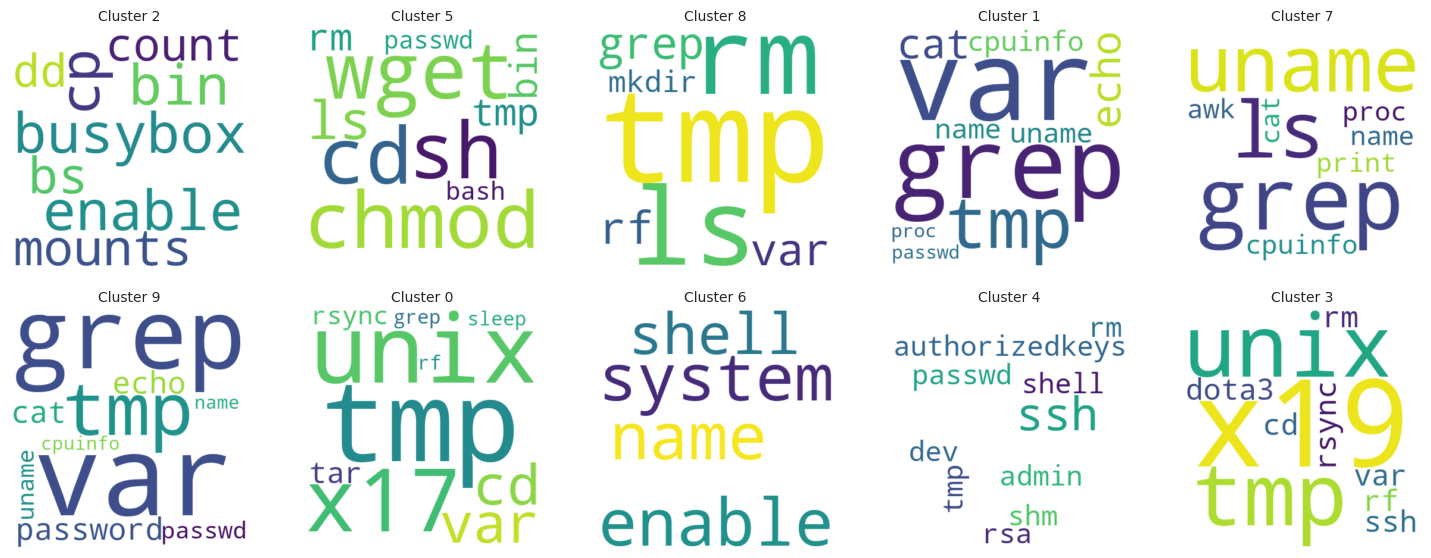

In [19]:

# Creazione del DataFrame da features e labels
df_cluster = pd.DataFrame(X)
df_cluster["cluster_kmeans"] = labels_kmeans_tuned

# Funzione per ottenere le parole più importanti per ciascun cluster
def get_top_words(df, n=10):
    top_words_per_cluster = {}
    for cluster in df["cluster_kmeans"].unique():
        subset = df[df["cluster_kmeans"] == cluster].drop(columns=["cluster_kmeans"])
        word_frequencies = subset.sum(axis=0)
        most_common_words = word_frequencies[word_frequencies > 0].sort_values(ascending=False).head(n).index.tolist()
        if most_common_words:
            top_words_per_cluster[cluster] = most_common_words
    return top_words_per_cluster

# Ottenere le parole chiave per ciascun cluster
top_words_per_cluster = get_top_words(df_cluster, n=10)

# Determinare il numero di cluster validi
num_clusters = len(top_words_per_cluster)

# Definiamo i parametri per la disposizione della griglia di subplot
columns = min(5, num_clusters)
rows = -(-num_clusters // columns)  # Ceiling division

# Creazione della figura con subplots
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, rows * 3))
axes = axes.flatten()

# Generazione delle word cloud per ciascun cluster
for idx, (cluster, words) in enumerate(top_words_per_cluster.items()):
    cluster_text = ' '.join(words)
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap="viridis").generate(cluster_text)
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster}', fontsize=10)
    axes[idx].axis('off')

# Rimuovere subplot vuoti
for j in range(num_clusters, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2)  # Più spazio tra i grafici
plt.show()


### Describe Cluster Patterns

- Analyze relationships or patterns among clusters:
  - Are clusters clearly separated or overlapping?
  - What types of terms dominate each cluster?

### Document Insights

- Summarize findings for each cluster with observations about their unique traits.

<center><b><font size=5>Assess Homogeneity and Intent Reflection<b><center>

Evaluate how well clusters align with intents and assess their homogeneity.

**Steps:**

- Match Clusters to Intents
- Analyze Homogeneity
- Draw Conclusions

### Match Clusters to Intents

- Compare each cluster to the dataset’s labeled intents (e.g., Persistence, Discovery, etc.).
- Use metrics like the homogeneity score or manual inspection to evaluate alignment.

Homogeneity Score: 0.8438

Intent Distribution Per Cluster:

Cluster 0:
Execution          84053
Discovery          84052
Persistence        84049
Other                310
Harmless             153
Defense Evasion       23
dtype: int64

Cluster 1:
Discovery          119849
Persistence        117434
Harmless             1779
Execution            1614
Defense Evasion       533
dtype: int64

Cluster 2:
Discovery          17606
Defense Evasion    17460
Execution             56
Harmless               2
dtype: int64

Cluster 3:
Discovery      5458
Execution      5458
Persistence    5458
Harmless          1
dtype: int64

Cluster 4:
Discovery          628
Defense Evasion    624
Execution          624
Persistence        429
Harmless             1
Impact               1
dtype: int64

Cluster 5:
Execution          913
Discovery          502
Defense Evasion    348
Persistence        115
Harmless            56
Impact              26
Other               17
dtype: int64

Cluster 6:
Discovery    201
Ex

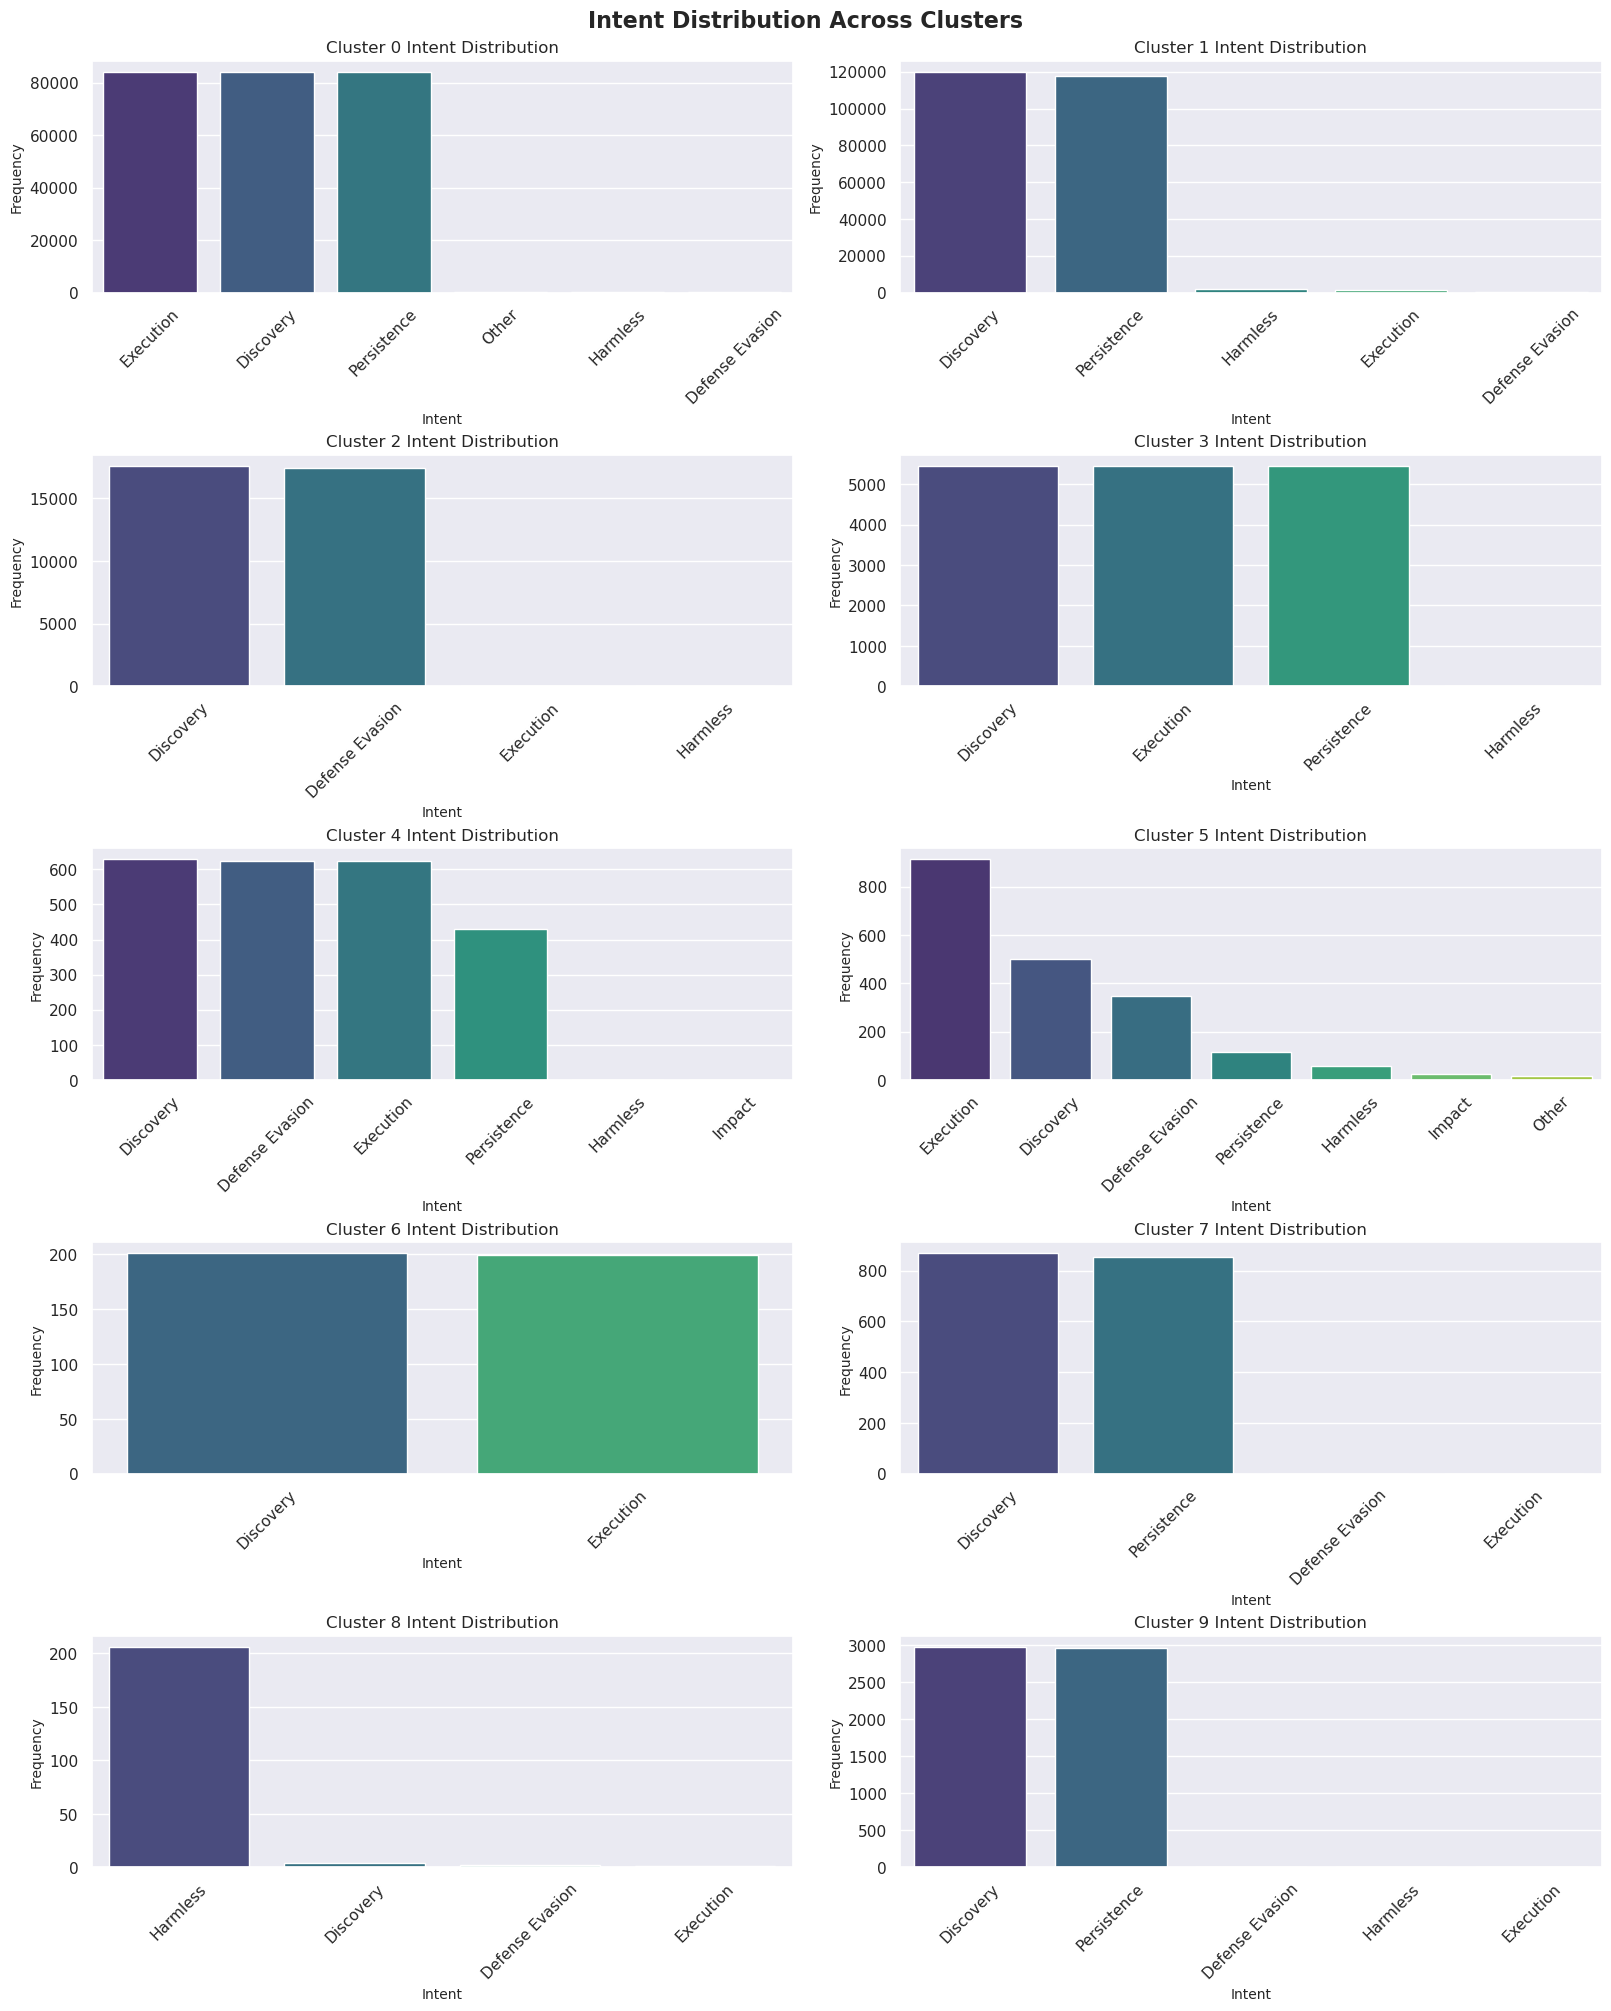

In [20]:
from sklearn.metrics import homogeneity_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import math

def evaluate_cluster_homogeneity(df, labels, intent_col="Set_Fingerprint"):
    """
    Evaluate cluster homogeneity by comparing clusters to labeled intents.

    Args:
        df (pd.DataFrame): The dataset containing the intents.
        labels (list or array): Cluster labels assigned to each session.
        intent_col (str): Column name containing the intents.

    Returns:
        None: Displays metrics and visualizations.
    """
    # Convert intents to strings for homogeneity score calculation
    intents_as_strings = df[intent_col].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
    
    # Calculate homogeneity score
    homogeneity = homogeneity_score(intents_as_strings, labels)
    print(f"Homogeneity Score: {homogeneity:.4f}")

    # Map clusters to intents
    df['cluster'] = labels
    cluster_intent_mapping = df.groupby('cluster')[intent_col].apply(lambda x: list(itertools.chain(*x)))

    # Visualize intent distribution per cluster
    print("\nIntent Distribution Per Cluster:")
    num_clusters = len(cluster_intent_mapping)
    num_columns = 2
    num_rows = math.ceil(num_clusters / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows), constrained_layout=True)

    for i, (cluster_label, intents) in enumerate(cluster_intent_mapping.items()):
        intent_counts = pd.Series(intents).value_counts()
        print(f"\nCluster {cluster_label}:")
        print(intent_counts)

        row_index = i // num_columns
        col_index = i % num_columns

        sns.barplot(ax=axes[row_index, col_index], x=intent_counts.index, y=intent_counts.values, palette='viridis')
        axes[row_index, col_index].set_title(f'Cluster {cluster_label} Intent Distribution', fontsize=12)
        axes[row_index, col_index].set_xlabel('Intent', fontsize=10)
        axes[row_index, col_index].set_ylabel('Frequency', fontsize=10)
        axes[row_index, col_index].tick_params(axis='x', rotation=45)

    # Hide empty subplots if the total number of clusters is not a multiple of num_columns
    for i in range(len(cluster_intent_mapping), num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle('Intent Distribution Across Clusters', fontsize=16, fontweight='bold')
    
    # Save the plot
    current_fig = plt.gcf()
    save_plot(current_fig, plot_directory, "intent_distribution_across_clusters", "png", global_overwrite)

    # Show the plot
    plt.show()

# Match clusters to intents and evaluate homogeneity
evaluate_cluster_homogeneity(df_features_tfidf_sampled, labels_kmeans_tuned, intent_col="Set_Fingerprint")

### Analyze Homogeneity

- Check if clusters are homogeneous (single intent) or mixed (multiple intents).
- Record insights into intent distribution within clusters.

### Draw Conclusions

- Discuss the implications of the findings:
  - Are clusters meaningful in terms of attack intents?
  - What could improve clustering accuracy?

<center><b><font size=5>Associate Clusters with Specific Attack Categories<b><center>

Analyze selected clusters to identify finer-grained attack categories and unique behaviors.

**Steps:**

- Select Representative Clusters
- Analyze Cluster Contents
- Relate to Practical Scenarios

### Select Representative Clusters

- Choose a few clusters that show interesting or unique behavior for deeper analysis.

### Analyze Cluster Contents

- Examine the sessions in these clusters:
  - Identify patterns or behaviors that distinguish them.
  - Determine subcategories of attacks within these clusters.

### Relate to Practical Scenarios

- Link findings to real-world attack methodologies:
  - Use graph-based techniques or manual inspection for further refinement.
- Present results with examples and interpretations to showcase finer attack categorization.